# Exploration of Kaggle wine dataset

https://www.kaggle.com/zynicide/wine-reviews

In [1]:
import os
import sys
import logging
import warnings
import json
import copy
import re
import time
import itertools
from collections import defaultdict

import unidecode

import numpy as np

import pandas as pd
import pandas_profiling

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import linear_model

import gensim
import spacy
from spacy import displacy
from spacy.tokens import Doc
from spacy.lang.en import English

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# Uncomment to print Gensim log messages
# logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
# logging.root.level = logging.INFO

sns.set_style('darkgrid')
sns.set_context('notebook')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
TYPES = {
    'country': str,
    'description': str,
    'designation': str,
    'points': int,
    'price': float,
    'province': str,
    'region_1': str,
    'region_2': str,
    'taster_name': str,
    'taster_twitter_handle': str,
    'title': str,
    'variety': str,
    'winery': str
}

df = pd.read_csv(
    './data/winemag-data-130k-v2.csv', dtype=TYPES, header=0, index_col=0)

with pd.option_context('display.max_rows', 3, 'display.max_columns', 300):
    display(df)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129970,France,"Big, rich and off-dry, this is powered by inte...",Lieu-dit Harth Cuvée Caroline,90,21.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...,Gewürztraminer,Domaine Schoffit


In [3]:
# pandas_profiling.ProfileReport(df, check_correlation=False, bins=10)

In [4]:
print('country: ', len(df['country'].unique()))
print('province: ', len(df['province'].unique()))
print('variety: ', len(df['variety'].unique()))

country:  44
province:  426
variety:  708


In [5]:
columns_to_merge = ['country', 'description', 'designation', 'province', 
                   'region_1', 'region_2', 'title', 'variety', 'winery']
df[columns_to_merge] = df[columns_to_merge].fillna('')

In [6]:
re_pattern = re.compile(r'-{1,2}[a-z]\.[a-z]\.?')  # Pattern to strip out name initials
def row2str(row):
    return re_pattern.sub(' ', unidecode.unidecode('. '.join(row[columns_to_merge])).lower())

start_time = time.time()
points, texts = zip(*[
    (row['points'], row2str(row))
    for _, row in df.iterrows()])
print('Converting dataframe took {} s'.format(time.time() - start_time))

print('points: ', len(points))
print('texts: ', len(texts))
print('Points:', points[0], ', text:', texts[0])

Converting dataframe took 65.52352905273438 s
points:  129971
texts:  129971
Points: 87 , text: italy. aromas include tropical fruit, broom, brimstone and dried herb. the palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.. vulka bianco. sicily & sardinia. etna. . nicosia 2013 vulka bianco  (etna). white blend. nicosia


In [7]:
Doc.set_extension('filtered_tokens', default='')

def filter_token(t):
    return not (t.is_stop or t.is_punct or t.is_space)

def tokenize_component(doc):
    doc._.set('filtered_tokens', tuple(t.lemma_ for t in doc if filter_token(t)))
    return doc

nlp = English()
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.add_pipe(tokenize_component)
print('NLP pipeline: ', nlp.pipe_names)

def gen_split_tokens(texts):
    return (doc._.filtered_tokens for doc in nlp.pipe(texts))

def gen_bigram(texts):
    texts = list(texts)
    bigram = gensim.models.phrases.Phrases(
        texts, 
        common_terms=set(["of", "with", "without", "and", "or", "the", "a"]))
    for t in texts:
        yield bigram[t]
        
def gen_tokens(texts):
    return gen_bigram(gen_split_tokens(t for t in texts))

NLP pipeline:  ['tokenize_component']


In [8]:
%time tokenized_texts = list(gen_tokens(texts))
print('tokenized_texts: ', len(tokenized_texts))
for i in range(3):
    print('Example tokens: ', tokenized_texts[i][:10])

CPU times: user 1min 11s, sys: 662 ms, total: 1min 12s
Wall time: 1min 12s
tokenized_texts:  129971
Example tokens:  ['italy', 'aroma', 'include', 'tropical_fruit', 'broom', 'brimstone', 'dry_herb', 'palate', 'not', 'overly']
Example tokens:  ['portugal', 'ripe', 'fruity', 'wine', 'smooth', 'structure', 'firm', 'tannin', 'fill', 'juicy']
Example tokens:  ['tart', 'snappy', 'flavor', 'lime', 'flesh_rind', 'dominate', 'green', 'pineapple', 'poke', 'crisp']


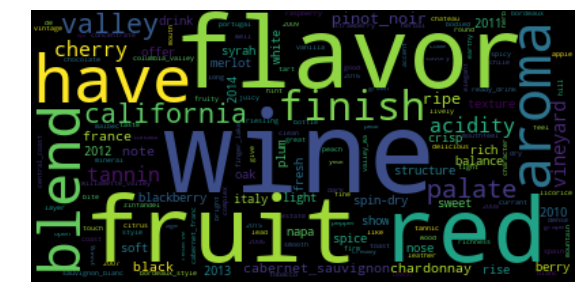

In [9]:
frequency = defaultdict(int)
for tokens in tokenized_texts:
    for token in tokens:
        frequency[token] += 1
        
wc = WordCloud(max_words=1000)
wc.fit_words(frequency)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
# Create a dictionary (This wil take a couple of minutes)
%time id2word = gensim.corpora.Dictionary(tokenized_texts)
print('id2word: ', id2word)

CPU times: user 4.41 s, sys: 19.1 ms, total: 4.43 s
Wall time: 4.44 s
id2word:  Dictionary(65615 unique tokens: ['italy', 'aroma', 'include', 'tropical_fruit', 'broom']...)


In [11]:
# ignore words that appear in less than 25 documents or more than 50% documents
id2word.filter_extremes(no_below=25, no_above=0.5)
id2word.compactify()
print('id2word: ', id2word, len(id2word))

id2word:  Dictionary(9196 unique tokens: ['italy', 'aroma', 'include', 'tropical_fruit', 'broom']...) 9196


In [12]:
%time corpus = [id2word.doc2bow(tokens) for tokens in tokenized_texts]

CPU times: user 3.26 s, sys: 34 ms, total: 3.3 s
Wall time: 3.3 s


In [13]:
for k, v in itertools.islice(id2word.items(), 5):
    print('{}: {}'.format(k, v))

0: italy
1: aroma
2: include
3: tropical_fruit
4: broom


## TF-IDF based score regression

In [14]:
# TF-IDF transformed corpus
# TF-IDF will take a couple of seconds on the full corpus
%time tfidf_model = gensim.models.TfidfModel(corpus, id2word=id2word)

CPU times: user 676 ms, sys: 5.46 ms, total: 681 ms
Wall time: 681 ms


In [15]:
tf_idf_corpus = tfidf_model[corpus]
print('tf_idf_corpus: ', type(tf_idf_corpus), len(tf_idf_corpus))
%time tfidf_csr = gensim.matutils.corpus2csc(tf_idf_corpus, num_terms=len(id2word), num_docs=len(tf_idf_corpus)).T
print('tfidf_csr: ', type(tfidf_csr), tfidf_csr.shape)

tf_idf_corpus:  <class 'gensim.interfaces.TransformedCorpus'> 129971
CPU times: user 4 s, sys: 104 ms, total: 4.11 s
Wall time: 4.11 s
tfidf_csr:  <class 'scipy.sparse.csr.csr_matrix'> (129971, 9196)


In [16]:
# Print some of the TF-IDF transformations
for i in range(3):
    print('Example tokens: ', tokenized_texts[i][:2])
    bow_test = id2word.doc2bow(tokenized_texts[i])
    tfidf_sample = tfidf_model[bow_test]
    print(tfidf_sample[:2])
    print([tfidf_csr[i,tfidf_sample[x][0]] for x in range(2)])

Example tokens:  ['italy', 'aroma']
[(0, 0.08180672279443169), (1, 0.05043075356016562)]
[0.081806722794431685, 0.050430753560165617]
Example tokens:  ['portugal', 'ripe']
[(23, 0.17032194421162705), (24, 0.08665319731999367)]
[0.17032194421162705, 0.086653197319993672]
Example tokens:  ['tart', 'snappy']
[(19, 0.09608243288830132), (36, 0.06299137039640883)]
[0.096082432888301317, 0.062991370396408827]


In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    tfidf_csr, np.array(points), test_size=0.05, random_state=42)

print('x_train: ', type(x_train), x_train.shape)
print('y_train: ', type(y_train), y_train.shape)
print('x_test: ', type(x_test), x_test.shape)
print('y_test: ', type(y_test), y_test.shape)

x_train:  <class 'scipy.sparse.csr.csr_matrix'> (123472, 9196)
y_train:  <class 'numpy.ndarray'> (123472,)
x_test:  <class 'scipy.sparse.csr.csr_matrix'> (6499, 9196)
y_test:  <class 'numpy.ndarray'> (6499,)


In [18]:
linreg_model = linear_model.Ridge(alpha=0.1)
%time linreg_model.fit(x_train, y_train)

CPU times: user 4.27 s, sys: 39.7 ms, total: 4.31 s
Wall time: 4.3 s


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

y_train_pred:  (123472,)
Mean absolute error: 1.1390805057683033
Variance score: 0.7722090715695946


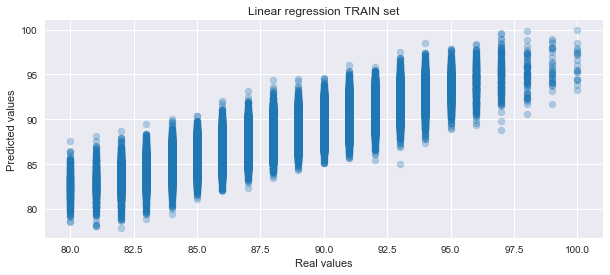

In [19]:
# Predictions from train set
y_train_pred = linreg_model.predict(x_train)
print('y_train_pred: ', y_train_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Variance score: {}'.format(r2_score(y_train, y_train_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_train, y_train_pred, alpha=.3)
plt.title('Linear regression TRAIN set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

y_test_pred:  (6499,)
Mean absolute error: 1.226384613009116
Variance score: 0.7419195349494927


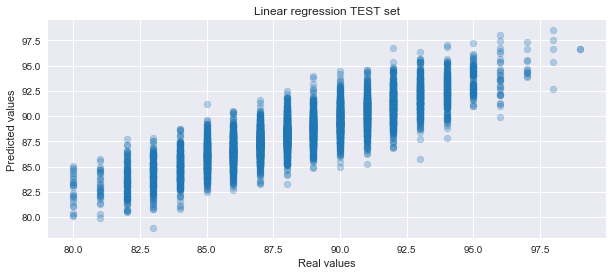

In [20]:
# Predictions from test set
y_test_pred = linreg_model.predict(x_test)
print('y_test_pred: ', y_test_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_test, y_test_pred)))
print('Variance score: {}'.format(r2_score(y_test, y_test_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_test, y_test_pred, alpha=.3)
plt.title('Linear regression TEST set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

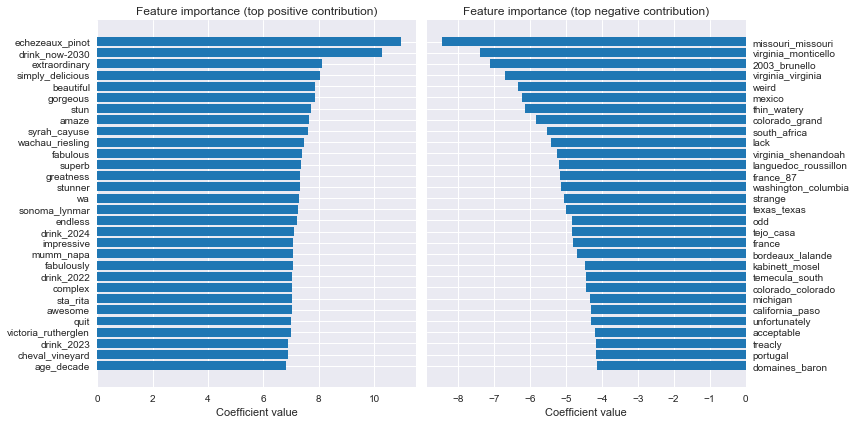

In [21]:
# Find top features

# Top features contributing positive effect
max_indices = linreg_model.coef_.argsort()[-30:][::-1]
max_values = linreg_model.coef_[max_indices]

names = [id2word.get(i) for i in max_indices]
y_pos = np.arange(len(names))

fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.barh(y_pos, max_values, align='center')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(names)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Coefficient value')
ax1.set_title('Feature importance (top positive contribution)')


# Top features contributing negative effect 
min_indices = linreg_model.coef_.argsort()[:30]
min_values = linreg_model.coef_[min_indices]

names = [id2word.get(i) for i in min_indices]
y_pos = np.arange(len(names))

ax2 = plt.subplot(122)
ax2.barh(y_pos, min_values, align='center')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(names)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_xlabel('Coefficient value')
ax2.set_title('Feature importance (top negative contribution)')
plt.tight_layout()
plt.show()

## LDA  based score regression

In [22]:
### LDA topic-modelling on a subset of documents
num_lda_topics = 50
%time lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_lda_topics, id2word=id2word, passes=2)
# Serialise the LDA model
# lda_model.save('./data/lda_wiki.model')
# Serialise corpus transformed to LDA space
# %time gensim.corpora.MmCorpus.serialize('./data/wiki_lda.mm', lda_model[mm_corpus])
# lda_model.print_topics(10)

CPU times: user 1min 15s, sys: 13.7 s, total: 1min 29s
Wall time: 1min 30s


In [23]:
lda_topics = lda_model.get_topics()
print('lda_topics: ', type(lda_topics), lda_topics.shape)

lda_corpus = lda_model[corpus]
print('lda_corpus: ', type(lda_corpus), len(lda_corpus))
%time lda_features_csr = gensim.matutils.corpus2csc(lda_corpus, num_terms=num_lda_topics, num_docs=len(lda_corpus)).T
print('lda_features: ', type(lda_features_csr), lda_features_csr.shape)

lda_topics:  <class 'numpy.ndarray'> (50, 9196)
lda_corpus:  <class 'gensim.interfaces.TransformedCorpus'> 129971
CPU times: user 1min 52s, sys: 229 ms, total: 1min 52s
Wall time: 1min 53s
lda_features:  <class 'scipy.sparse.csr.csr_matrix'> (129971, 50)


In [24]:
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
20     5.240688        1       1  0.119034 -0.034015
46     4.636868        1       2  0.105288  0.010398
49     3.946263        1       3  0.050391  0.240204
29     3.637349        1       4  0.074073 -0.062994
22     3.370058        1       5  0.066364 -0.008040
5      3.320263        1       6  0.150254 -0.015474
9      3.312321        1       7  0.081613 -0.051097
40     3.242978        1       8  0.077052 -0.058074
32     2.911638        1       9  0.099207 -0.052833
13     2.896776        1      10 -0.139241  0.179685
42     2.895151        1      11  0.161910 -0.035852
31     2.781574        1      12 -0.009739 -0.105903
1      2.772597        1      13 -0.087530  0.145790
16     2.668678        1      14 -0.071641 -0.057841
23     2.478084        1      15 -0.040396  0.149663
25     2.313090        1      16 -0.170969 -0.039531
18     2.309473        1      17 -0.062801 -0.121150
6      2.263926        1      18 -0.114672 -0.102524
21     2.202069        1      19  0.043719 -0.002332
14     2.141195        1      20 -0.160827 -0.034352
45     2.033349        1      21 -0.140527 -0.103825
12     2.013854        1      22 -0.070120 -0.046001
7      1.998768        1      23  0.122352 -0.017965
28     1.916750        1      24  0.074996 -0.061123
44     1.890721        1      25 -0.035869 -0.055154
47     1.869503        1      26  0.081119 -0.034819
38     1.839980        1      27  0.113152  0.085317
26     1.810057        1      28 -0.026201  0.200917
3      1.681227        1      29  0.097309 -0.051823
30     1.679897        1      30 -0.143239 -0.054648
27     1.667371        1      31  0.077560  0.129157
33     1.663153        1      32  0.084975 -0.022380
2      1.661375        1      33 -0.150357  0.105631
15     1.567857        1      34  0.057643 -0.063504
17     1.188764        1      35 -0.009968 -0.042417
11     1.142842        1      36 -0.119330 -0.064129
24     1.107989        1      37 -0.072207 -0.060302
0      1.098166        1      38 -0.072095 -0.065512
8      1.045835        1      39 -0.021686 -0.062358
48     0.961123        1      40  0.062468 -0.029654
4      0.844127        1      41 -0.112149  0.004091
35     0.815057        1      42  0.061289  0.179645
10     0.799318        1      43  0.077845 -0.015664
34     0.784569        1      44 -0.015638  0.173184
37     0.676644        1      45 -0.040861  0.052120
36     0.668977        1      46 -0.080011  0.006689
19     0.610321        1      47  0.017585 -0.031658
41     0.607706        1      48 -0.028963  0.030030
43     0.572620        1      49  0.060079 -0.006317
39     0.441042        1      50 -0.020238 -0.021254, topic_info=     Category          Freq                Term         Total  loglift  \
term                                                                     
189   Default  39584.000000          california  39584.000000  30.0000   
32    Default  57863.000000                 red  57863.000000  29.0000   
104   Default  27772.000000          pinot_noir  27772.000000  28.0000   
243   Default  27900.000000          chardonnay  27900.000000  27.0000   
59    Default  37200.000000              valley  37200.000000  26.0000   
141   Default  22818.000000              france  22818.000000  25.0000   
0     Default  20495.000000               italy  20495.000000  24.0000   
22    Default  40897.000000               blend  40897.000000  23.0000   
190   Default  14028.000000                napa  14028.000000  22.0000   
300   Default  13411.000000                rise  13411.000000  21.0000   
21    Default  20630.000000               white  20630.000000  20.0000   
662   Default  11978.000000     columbia_valley  11978.000000  19.0000   
192   Default  25857.000000  cabernet_sauvignon  25857.000000  18.0000   
601   Default  14390.000000               syrah  14390.000000  17.0000   
380   Default  29

In [25]:
x_train_lda, x_test_lda, y_train_lda, y_test_lda = train_test_split(
    lda_features_csr, np.array(points), test_size=0.05, random_state=42)

print('x_train_lda: ', type(x_train_lda), x_train_lda.shape)
print('y_train_lda: ', type(y_train_lda), y_train_lda.shape)
print('x_test_lda: ', type(x_test_lda), x_test_lda.shape)
print('y_test_lda: ', type(y_test_lda), y_test_lda.shape)

x_train_lda:  <class 'scipy.sparse.csr.csr_matrix'> (123472, 50)
y_train_lda:  <class 'numpy.ndarray'> (123472,)
x_test_lda:  <class 'scipy.sparse.csr.csr_matrix'> (6499, 50)
y_test_lda:  <class 'numpy.ndarray'> (6499,)


In [26]:
linreg_lda_model = linear_model.Ridge(alpha=5)
%time linreg_lda_model.fit(x_train_lda, y_train_lda)

CPU times: user 627 ms, sys: 20.4 ms, total: 647 ms
Wall time: 591 ms


Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

y_train_lda_pred:  (123472,)
Mean absolute error: 2.165457426145969
Variance score: 0.2212114604586216


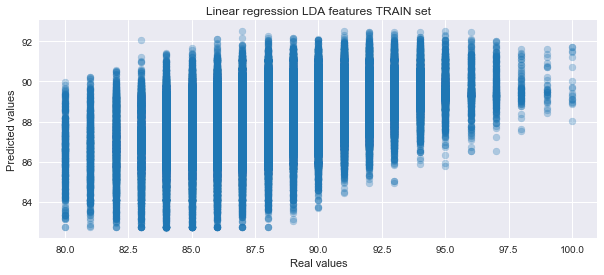

In [27]:
# Predictions from train set
y_train_lda_pred = linreg_lda_model.predict(x_train_lda)
print('y_train_lda_pred: ', y_train_lda_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_train_lda, y_train_lda_pred)))
print('Variance score: {}'.format(r2_score(y_train_lda, y_train_lda_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_train_lda, y_train_lda_pred, alpha=.3)
plt.title('Linear regression LDA features TRAIN set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

y_test_lda_pred:  (6499,)
Mean absolute error: 2.2001610890390206
Variance score: 0.22167067939645957


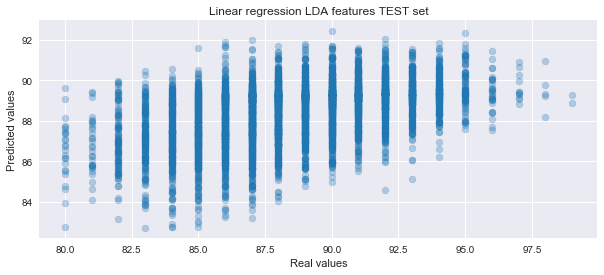

In [28]:
# Predictions from test set
y_test_lda_pred = linreg_lda_model.predict(x_test_lda)
print('y_test_lda_pred: ', y_test_lda_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_test_lda, y_test_lda_pred)))
print('Variance score: {}'.format(r2_score(y_test_lda, y_test_lda_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_test_lda, y_test_lda_pred, alpha=.3)
plt.title('Linear regression LDA features TEST set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

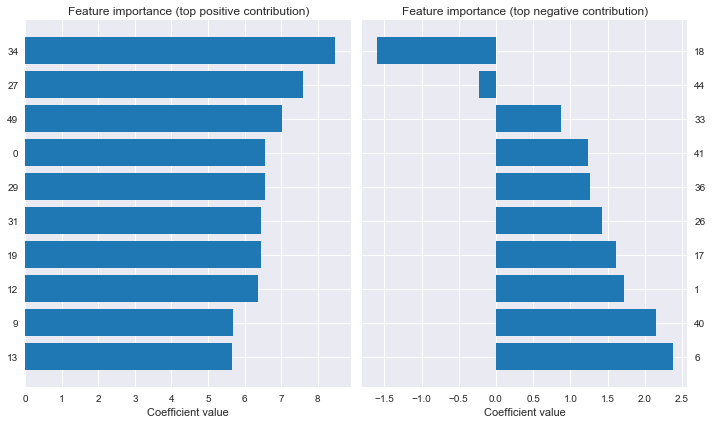

In [29]:
# Find top features

# Top postive contributing features
max_indices = linreg_lda_model.coef_.argsort()[-10:][::-1]
max_values = linreg_lda_model.coef_[max_indices]
y_pos = np.arange(len(max_indices))

fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot(121)
ax1.barh(y_pos, max_values, align='center')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(max_indices)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Coefficient value')
ax1.set_title('Feature importance (top positive contribution)')


# Top negative contributing features
min_indices = linreg_lda_model.coef_.argsort()[:10]
min_values = linreg_lda_model.coef_[min_indices]
y_pos = np.arange(len(min_indices))

ax2 = plt.subplot(122)
ax2.barh(y_pos, min_values, align='center')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(min_indices)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_xlabel('Coefficient value')
ax2.set_title('Feature importance (top negative contribution)')
plt.tight_layout()
plt.show()

GOOD:


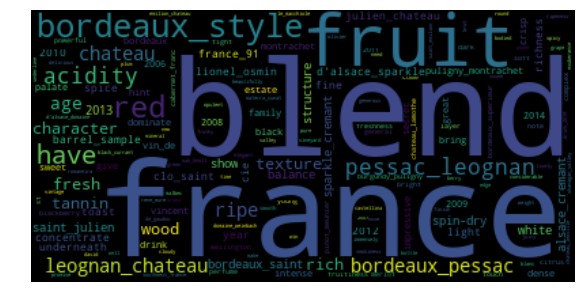

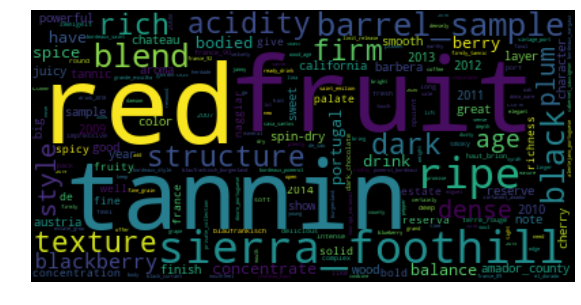




BAD:


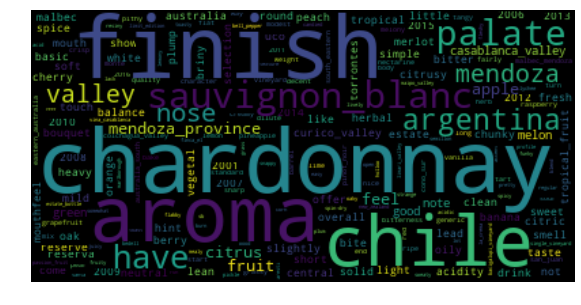

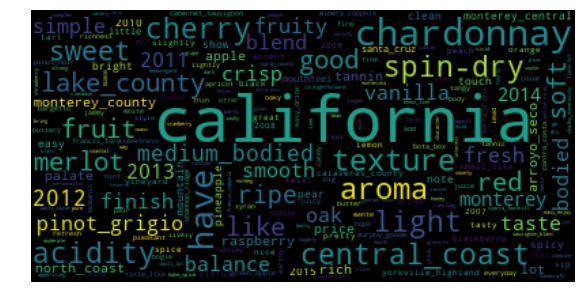

In [30]:
def show_topic(idx):
    freqs = {}
    for widx in range(lda_topics.shape[1]):
        freqs[id2word[widx]] = lda_topics[idx, widx]

    wc = WordCloud(max_words=1000)
    wc.fit_words(freqs)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
print('GOOD:')
show_topic(max_indices[0])
show_topic(max_indices[1])

print('\n\n')
print('BAD:')
show_topic(min_indices[0])
show_topic(min_indices[1])